In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
import alphalens as al
%matplotlib inline

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu'] #, 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd']#, 'AP', 'sp']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [3]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2014,5,1)
end_date = datetime.date(2020,7,14)

sim_products = commod_all_mkts
need_shift = 1
freq = 'd'
delim = '-'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [delim.join((asset, col)) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False)

loading mkt = rb, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2014, 5, 1), 'end_date': datetime.date(2020, 7, 10)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2014, 5, 1), 'end_date': datetime.date(2020, 7, 10)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2014, 5, 1), 'end_date': datetime.date(2020, 7, 10)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2014, 5, 1), 'end_date': datetime.date(2020, 7, 10)}
loading mkt = jm, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2014, 5, 1), 'end_date': datetime.date(2020, 7, 10)}
loading mkt = ru, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2014, 5, 1), 'end_date': datetime.date(2020, 7, 10)}
loadin

In [9]:
def run_xs_test(input_args):
    product_list = input_args['product_list']
    win_s_list = input_args['win_s_list']
    win_l_list = input_args['win_l_list']
    win_list = list(set(win_s_list).union(set(win_l_list)))
    scale_win = input_args.get('scaling_win', [60, 240])
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.0)
    quantile_cutoff = input_args.get('quantile', 0.2)
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    select_cols = []
    for col in df.columns:
        col_split = col.split(delim)
        if col_split[0] in product_list:
            select_cols.append(col)
    xdf= df[select_cols].copy()

    for asset in product_list:
        for win in win_list:
            xdf[delim.join((asset, 'ema' + str(win)))] = dh.EMA(xdf, win, field = 'close', prefix = asset + delim)
        xdf[delim.join((asset, 'std'))] = dh.STDEV(xdf, scale_win[0], field = 'close', prefix = asset + delim)        
        for idx, (win_s, win_l) in enumerate(zip(win_s_list, win_l_list)):
            xdf[delim.join((asset, 'y' + str(idx)))] = (xdf[delim.join((asset, 'ema' + str(win_s)))] \
                                                           - xdf[delim.join((asset, 'ema' + str(win_l)))]) \
                                                        /xdf[delim.join((asset, 'std'))]            
            xdf[delim.join((asset, 'z' + str(idx)))] = xdf[delim.join((asset, 'y' + str(idx)))] \
                                                        /dh.STDEV(xdf, scale_win[1], field = 'y' + str(idx), prefix = asset + delim)                        
            xdf[delim.join((asset, 'sig' + str(idx)))] = xdf[delim.join((asset, 'z' + str(idx)))].apply(lambda x: x * np.exp(-x*x/4)/0.89)            
        xdf[delim.join((asset, 'avgsig'))] = xdf[[delim.join((asset, 'sig' + str(idx))) for idx in range(len(win_s_list))]].mean(axis=1)
        
    total_risk = 10000000.0
    margin_rate = [0.08, 0.08]
    pnl_tenors = ['1y', '2y', '3y', '4y']
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0

    xdf['rebal_seqno'] = range(len(xdf.index))

    kcut = int(quantile_cutoff * len(product_list))
    upper_rank = len(product_list) - kcut
    lower_rank = 1 + kcut 
    rank_df = xdf[[delim.join((asset, 'avgsig')) for asset in product_list]].rank(axis=1)
    rank_df.columns = product_list    

    long_pos = pd.DataFrame(0, columns = product_list, index = xdf.index)
    short_pos = pd.DataFrame(0, columns = product_list, index = xdf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in product_list:
            long_tmp.loc[(rank_df[asset]>upper_rank) & rebal_flag, asset] = 1.0
            long_tmp.loc[(rank_df[asset]<=upper_rank) & rebal_flag, asset] = 0.0
            short_tmp.loc[(rank_df[asset]<lower_rank) & rebal_flag, asset] = 1.0
            short_tmp.loc[(rank_df[asset]>=lower_rank) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_sum = long_tmp.sum(axis=1)
        short_sum = short_tmp.sum(axis=1)
        long_pos = long_pos + long_tmp.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp.div(short_sum,axis=0)
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []

    for asset, offset in zip(product_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk \
                    /xdf[delim.join((asset,'std'))].astype('float')).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk \
                    /xdf[delim.join((asset,'std'))].astype('float')).shift(1).fillna(method='ffill')
        xdf[delim.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        xdf[delim.join((asset, 'traded_price'))] = xdf[delim.join((asset, 'open'))]
        xdf[delim.join((asset, 'pos'))].iloc[-1] = 0
        xdf[delim.join((asset, 'cost'))] = \
                abs(xdf[delim.join((asset, 'pos'))] \
                - xdf[delim.join((asset, 'pos'))].shift(1)) * offset
        xdf[delim.join((asset, 'cost'))] = xdf[delim.join((asset, 'cost'))].fillna(0.0)
        fields = [delim.join((asset, field)) for field in extract_fields] 
        tdf = xdf[fields]
        tdf.columns = extract_fields
        tdf.index.name = 'date'    
        if freq == 'm':
            tdf['date'] = xdf['date']
            tdf['min_id'] = xdf['min_id']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    # xdf[[(asset, 'pos') for asset in product_list]].to_csv(prefix + run_name + '_pos.csv')
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df}
    return res

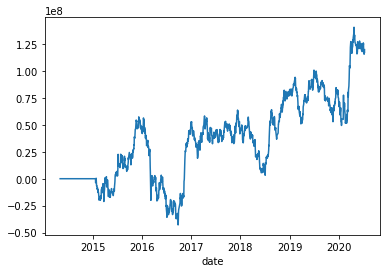

                    commod_mkts-6-1
avg_pnl_1y             8.847411e+04
avg_pnl_2y             2.182786e+05
avg_pnl_3y             1.055105e+05
avg_pnl_4y             1.494314e+05
max_dd_period_1y      -1.880000e+02
max_dd_period_2y      -2.040000e+02
max_dd_period_3y      -2.050000e+02
max_dd_period_4y      -2.050000e+02
max_drawdown_1y       -5.043480e+07
max_drawdown_2y       -5.134236e+07
max_drawdown_3y       -6.046198e+07
max_drawdown_4y       -6.046198e+07
num_days_1y            2.440000e+02
num_days_2y            4.870000e+02
num_days_3y            7.320000e+02
num_days_4y            9.740000e+02
profit_dd_ratio_1y     4.280315e-01
profit_dd_ratio_2y     2.070448e+00
profit_dd_ratio_3y     1.277393e+00
profit_dd_ratio_4y     2.407235e+00
sharp_ratio_1y         3.938138e-01
sharp_ratio_2y         1.080707e+00
sharp_ratio_3y         5.465447e-01
sharp_ratio_4y         7.643448e-01
std_pnl_1y             3.566363e+06
std_pnl_2y             3.206295e+06
std_pnl_3y             3.064

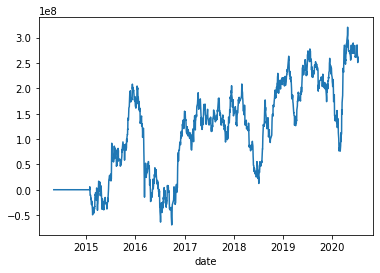

                    commod_mkts-6-3
avg_pnl_1y            -4.480796e+04
avg_pnl_2y             4.661044e+05
avg_pnl_3y             1.734364e+05
avg_pnl_4y             2.992019e+05
max_dd_period_1y      -2.250000e+02
max_dd_period_2y      -2.250000e+02
max_dd_period_3y      -2.250000e+02
max_dd_period_4y      -2.250000e+02
max_drawdown_1y       -2.015251e+08
max_drawdown_2y       -2.015251e+08
max_drawdown_3y       -2.015251e+08
max_drawdown_4y       -2.015251e+08
num_days_1y            2.440000e+02
num_days_2y            4.870000e+02
num_days_3y            7.320000e+02
num_days_4y            9.740000e+02
profit_dd_ratio_1y    -5.425202e-02
profit_dd_ratio_2y     1.126375e+00
profit_dd_ratio_3y     6.299736e-01
profit_dd_ratio_4y     1.446086e+00
sharp_ratio_1y        -7.086084e-02
sharp_ratio_2y         8.094274e-01
sharp_ratio_3y         3.131099e-01
sharp_ratio_4y         5.398466e-01
std_pnl_1y             1.003804e+07
std_pnl_2y             9.141249e+06
std_pnl_3y             8.793

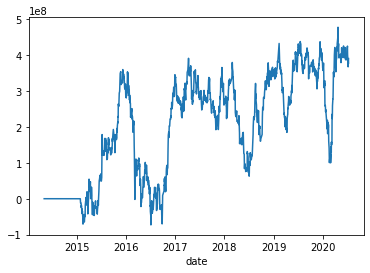

                    commod_mkts-6-5
avg_pnl_1y            -1.423398e+05
avg_pnl_2y             6.111224e+05
avg_pnl_3y             1.381001e+05
avg_pnl_4y             4.152693e+05
max_dd_period_1y      -2.250000e+02
max_dd_period_2y      -2.250000e+02
max_dd_period_3y      -2.250000e+02
max_dd_period_4y      -2.250000e+02
max_drawdown_1y       -3.377634e+08
max_drawdown_2y       -3.377634e+08
max_drawdown_3y       -3.377634e+08
max_drawdown_4y       -3.377634e+08
num_days_1y            2.440000e+02
num_days_2y            4.870000e+02
num_days_3y            7.320000e+02
num_days_4y            9.740000e+02
profit_dd_ratio_1y    -1.028262e-01
profit_dd_ratio_2y     8.811395e-01
profit_dd_ratio_3y     2.992902e-01
profit_dd_ratio_4y     1.197502e+00
sharp_ratio_1y        -1.410506e-01
sharp_ratio_2y         6.560584e-01
sharp_ratio_3y         1.534857e-01
sharp_ratio_4y         4.629540e-01
std_pnl_1y             1.601961e+07
std_pnl_2y             1.478720e+07
std_pnl_3y             1.428

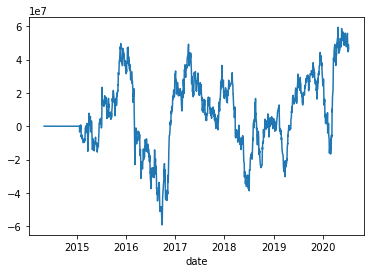

                    commod_mkts-8-1
avg_pnl_1y             8.914225e+04
avg_pnl_2y             1.543359e+05
avg_pnl_3y             3.555649e+04
avg_pnl_4y             7.661071e+04
max_dd_period_1y      -7.800000e+01
max_dd_period_2y      -7.800000e+01
max_dd_period_3y      -2.010000e+02
max_dd_period_4y      -4.490000e+02
max_drawdown_1y       -6.088857e+07
max_drawdown_2y       -6.088857e+07
max_drawdown_3y       -7.518856e+07
max_drawdown_4y       -8.791731e+07
num_days_1y            2.440000e+02
num_days_2y            4.870000e+02
num_days_3y            7.320000e+02
num_days_4y            9.740000e+02
profit_dd_ratio_1y     3.572215e-01
profit_dd_ratio_2y     1.234412e+00
profit_dd_ratio_3y     3.461610e-01
profit_dd_ratio_4y     8.487388e-01
sharp_ratio_1y         4.215776e-01
sharp_ratio_2y         7.931684e-01
sharp_ratio_3y         1.873496e-01
sharp_ratio_4y         3.841509e-01
std_pnl_1y             3.356652e+06
std_pnl_2y             3.088886e+06
std_pnl_3y             3.012

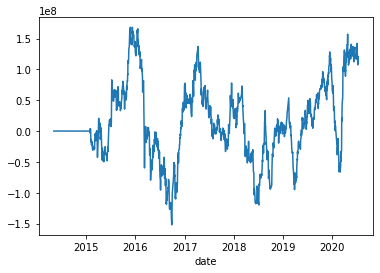

                    commod_mkts-8-3
avg_pnl_1y             3.232083e+05
avg_pnl_2y             4.303907e+05
avg_pnl_3y             1.214737e+05
avg_pnl_4y             1.851680e+05
max_dd_period_1y      -7.800000e+01
max_dd_period_2y      -7.800000e+01
max_dd_period_3y      -2.020000e+02
max_dd_period_4y      -4.500000e+02
max_drawdown_1y       -1.947418e+08
max_drawdown_2y       -1.947418e+08
max_drawdown_3y       -1.977173e+08
max_drawdown_4y       -2.570215e+08
num_days_1y            2.440000e+02
num_days_2y            4.870000e+02
num_days_3y            7.320000e+02
num_days_4y            9.740000e+02
profit_dd_ratio_1y     4.049609e-01
profit_dd_ratio_2y     1.076298e+00
profit_dd_ratio_3y     4.497267e-01
profit_dd_ratio_4y     7.017065e-01
sharp_ratio_1y         5.273031e-01
sharp_ratio_2y         7.683751e-01
sharp_ratio_3y         2.220882e-01
sharp_ratio_4y         3.319973e-01
std_pnl_1y             9.730215e+06
std_pnl_2y             8.891803e+06
std_pnl_3y             8.682

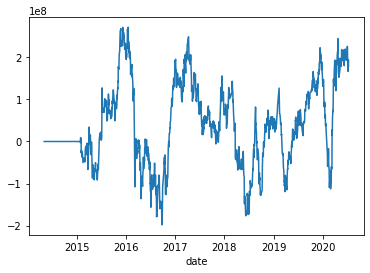

                    commod_mkts-8-5
avg_pnl_1y             5.291422e+05
avg_pnl_2y             6.591468e+05
avg_pnl_3y             1.514243e+05
avg_pnl_4y             2.889447e+05
max_dd_period_1y      -7.800000e+01
max_dd_period_2y      -7.800000e+01
max_dd_period_3y      -7.800000e+01
max_dd_period_4y      -4.240000e+02
max_drawdown_1y       -3.352624e+08
max_drawdown_2y       -3.352624e+08
max_drawdown_3y       -3.352624e+08
max_drawdown_4y       -4.253712e+08
num_days_1y            2.440000e+02
num_days_2y            4.870000e+02
num_days_3y            7.320000e+02
num_days_4y            9.740000e+02
profit_dd_ratio_1y     3.851034e-01
profit_dd_ratio_2y     9.574724e-01
profit_dd_ratio_3y     3.306144e-01
profit_dd_ratio_4y     6.616155e-01
sharp_ratio_1y         5.318782e-01
sharp_ratio_2y         7.211716e-01
sharp_ratio_3y         1.700018e-01
sharp_ratio_4y         3.193322e-01
std_pnl_1y             1.579285e+07
std_pnl_2y             1.450921e+07
std_pnl_3y             1.413

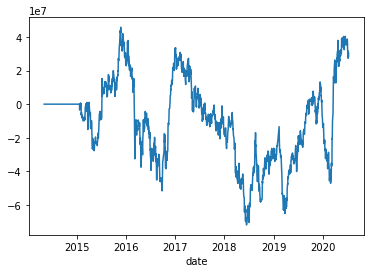

                    commod_mkts-10-1
avg_pnl_1y              2.054506e+05
avg_pnl_2y              1.851493e+05
avg_pnl_3y              3.767059e+04
avg_pnl_4y              6.171838e+04
max_dd_period_1y       -7.800000e+01
max_dd_period_2y       -7.800000e+01
max_dd_period_3y       -3.390000e+02
max_dd_period_4y       -5.270000e+02
max_drawdown_1y        -6.031310e+07
max_drawdown_2y        -6.031310e+07
max_drawdown_3y        -7.553289e+07
max_drawdown_4y        -1.054686e+08
num_days_1y             2.440000e+02
num_days_2y             4.870000e+02
num_days_3y             7.320000e+02
num_days_4y             9.740000e+02
profit_dd_ratio_1y      8.311617e-01
profit_dd_ratio_2y      1.494994e+00
profit_dd_ratio_3y      3.650711e-01
profit_dd_ratio_4y      5.699680e-01
sharp_ratio_1y          9.976411e-01
sharp_ratio_2y          9.361078e-01
sharp_ratio_3y          1.998345e-01
sharp_ratio_4y          3.217448e-01
std_pnl_1y              3.269138e+06
std_pnl_2y              3.139761e+06
s

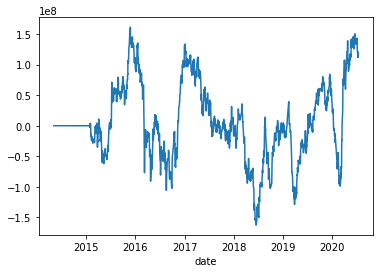

                    commod_mkts-10-3
avg_pnl_1y              4.380818e+05
avg_pnl_2y              4.964031e+05
avg_pnl_3y              1.175089e+05
avg_pnl_4y              1.661540e+05
max_dd_period_1y       -7.800000e+01
max_dd_period_2y       -7.800000e+01
max_dd_period_3y       -3.390000e+02
max_dd_period_4y       -5.270000e+02
max_drawdown_1y        -1.829353e+08
max_drawdown_2y        -1.829353e+08
max_drawdown_3y        -1.998752e+08
max_drawdown_4y        -2.957884e+08
num_days_1y             2.440000e+02
num_days_2y             4.870000e+02
num_days_3y             7.320000e+02
num_days_4y             9.740000e+02
profit_dd_ratio_1y      5.843157e-01
profit_dd_ratio_2y      1.321496e+00
profit_dd_ratio_3y      4.303512e-01
profit_dd_ratio_4y      5.471276e-01
sharp_ratio_1y          7.324058e-01
sharp_ratio_2y          8.739923e-01
sharp_ratio_3y          2.149354e-01
sharp_ratio_4y          2.996354e-01
std_pnl_1y              9.495190e+06
std_pnl_2y              9.016275e+06
s

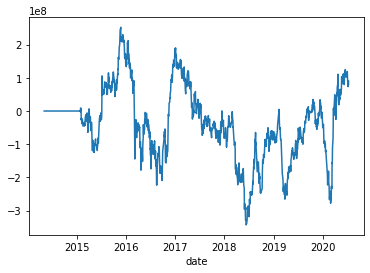

                    commod_mkts-10-5
avg_pnl_1y              6.255184e+05
avg_pnl_2y              7.566413e+05
avg_pnl_3y              1.110718e+05
avg_pnl_4y              1.997121e+05
max_dd_period_1y       -1.300000e+02
max_dd_period_2y       -1.300000e+02
max_dd_period_3y       -3.360000e+02
max_dd_period_4y       -5.240000e+02
max_drawdown_1y        -3.127521e+08
max_drawdown_2y        -3.127521e+08
max_drawdown_3y        -3.621596e+08
max_drawdown_4y        -5.330316e+08
num_days_1y             2.440000e+02
num_days_2y             4.870000e+02
num_days_3y             7.320000e+02
num_days_4y             9.740000e+02
profit_dd_ratio_1y      4.880111e-01
profit_dd_ratio_2y      1.178199e+00
profit_dd_ratio_3y      2.244993e-01
profit_dd_ratio_4y      3.649307e-01
sharp_ratio_1y          6.393872e-01
sharp_ratio_2y          8.215919e-01
sharp_ratio_3y          1.246912e-01
sharp_ratio_4y          2.202081e-01
std_pnl_1y              1.553018e+07
std_pnl_2y              1.461956e+07
s

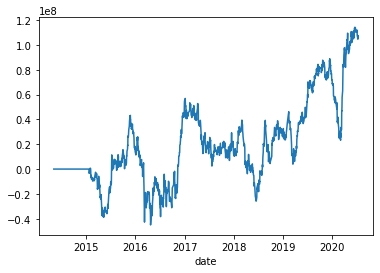

                    commod_mkts-12-1
avg_pnl_1y              1.600615e+05
avg_pnl_2y              2.440808e+05
avg_pnl_3y              1.148947e+05
avg_pnl_4y              1.347889e+05
max_dd_period_1y       -8.100000e+01
max_dd_period_2y       -8.100000e+01
max_dd_period_3y       -8.100000e+01
max_dd_period_4y       -5.270000e+02
max_drawdown_1y        -6.557798e+07
max_drawdown_2y        -6.557798e+07
max_drawdown_3y        -6.557798e+07
max_drawdown_4y        -8.254101e+07
num_days_1y             2.440000e+02
num_days_2y             4.870000e+02
num_days_3y             7.320000e+02
num_days_4y             9.740000e+02
profit_dd_ratio_1y      5.955505e-01
profit_dd_ratio_2y      1.812611e+00
profit_dd_ratio_3y      1.282487e+00
profit_dd_ratio_4y      1.590535e+00
sharp_ratio_1y          7.819797e-01
sharp_ratio_2y          1.248499e+00
sharp_ratio_3y          6.126844e-01
sharp_ratio_4y          6.911713e-01
std_pnl_1y              3.249314e+06
std_pnl_2y              3.103458e+06
s

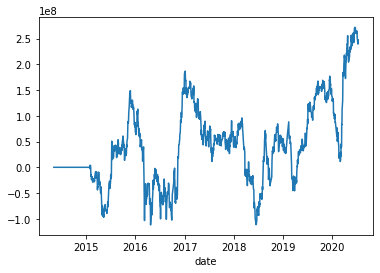

                    commod_mkts-12-3
avg_pnl_1y              5.408098e+05
avg_pnl_2y              6.620865e+05
avg_pnl_3y              2.386123e+05
avg_pnl_4y              3.123435e+05
max_dd_period_1y       -7.800000e+01
max_dd_period_2y       -7.800000e+01
max_dd_period_3y       -1.070000e+02
max_dd_period_4y       -5.270000e+02
max_drawdown_1y        -1.658829e+08
max_drawdown_2y        -1.658829e+08
max_drawdown_3y        -2.071864e+08
max_drawdown_4y        -2.982222e+08
num_days_1y             2.440000e+02
num_days_2y             4.870000e+02
num_days_3y             7.320000e+02
num_days_4y             9.740000e+02
profit_dd_ratio_1y      7.954866e-01
profit_dd_ratio_2y      1.943758e+00
profit_dd_ratio_3y      8.430294e-01
profit_dd_ratio_4y      1.020120e+00
sharp_ratio_1y          9.123677e-01
sharp_ratio_2y          1.159341e+00
sharp_ratio_3y          4.354446e-01
sharp_ratio_4y          5.520882e-01
std_pnl_1y              9.409681e+06
std_pnl_2y              9.065755e+06
s

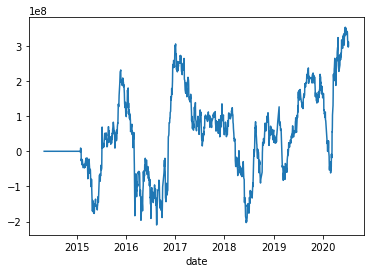

                    commod_mkts-12-5
avg_pnl_1y              6.374892e+05
avg_pnl_2y              9.396857e+05
avg_pnl_3y              2.830222e+05
avg_pnl_4y              4.392803e+05
max_dd_period_1y       -1.650000e+02
max_dd_period_2y       -1.650000e+02
max_dd_period_3y       -1.800000e+02
max_dd_period_4y       -5.240000e+02
max_drawdown_1y        -2.986945e+08
max_drawdown_2y        -2.986945e+08
max_drawdown_3y        -3.376964e+08
max_drawdown_4y        -5.081653e+08
num_days_1y             2.440000e+02
num_days_2y             4.870000e+02
num_days_3y             7.320000e+02
num_days_4y             9.740000e+02
profit_dd_ratio_1y      5.207575e-01
profit_dd_ratio_2y      1.532090e+00
profit_dd_ratio_3y      6.134868e-01
profit_dd_ratio_4y      8.419682e-01
sharp_ratio_1y          6.536456e-01
sharp_ratio_2y          1.008196e+00
sharp_ratio_3y          3.173778e-01
sharp_ratio_4y          4.742455e-01
std_pnl_1y              1.548213e+07
std_pnl_2y              1.479579e+07
s

In [12]:
res = {}
stats_list = []
cum_list = []

product_list =  ind_all_mkts # ind_all_mkts #
product_name = 'commod_mkts'
save_loc = "C:\\dev\\data\\daily_xsmadist_" + product_name + "_"
sratio = {}
index_list = [6, 8, 10, 12]
column_list = [1, 3, 5]
ls_scaler = 3
for yr in range(4):
    sratio[yr] = pd.DataFrame(0, index = index_list, columns = column_list)
for win in index_list:
    for rebal in column_list:
        run_args = {}
        run_args['run_name'] = run_name = '-'.join([product_name, str(win), str(rebal)])
        run_args['cost_ratio'] = 0.3
        run_args['product_list'] = product_list
        run_args['win_s_list'] = [ i * win for i in range(1, 4)]
        run_args['win_l_list'] = [ i * win * ls_scaler for i in range(1, 4)]        
        run_args['scaling_win'] = [60, 120]
        run_args['prefix'] = save_loc        
        run_args['rebal_freq'] = rebal
        res = run_xs_test(run_args)
        res['cum_pnl'].plot()
        plt.show()
        cum_list.append(res['cum_pnl'])
        print(res['pnl_stats'])
        for yr in range(4):
            lbl = 'sharp_ratio_' + str(yr+1) + 'y'
            sratio[yr][rebal].loc[win] = res['pnl_stats'][run_name][lbl]
        stats_list.append(res['pnl_stats'])

cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'xsmom_pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'xsmom_stats.csv')
for yr in range(4):
    print(sratio[yr])


In [13]:
save_xl = True
if save_xl:
    xlfile = save_loc + "sratio_heatmap.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for yr in range(4):
        lbl = 'sharp_ratio_' + str(yr+1) + 'y'
        sratio[yr].to_excel(writer, lbl, startcol= 0, startrow=1)
    writer.save()    

Series([], Name: jm-close, dtype: float64)
